In [2]:
import random
import math
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
class Cache:
    
    def __init__(self, cache_size):
        self.cache = [i for i in range(1, cache_size + 1)]
        self.cache_size = cache_size
    
    def get_element(self, index, remove):
        if (index in self.cache):
            return True
        else:
            self.cache.append(index)
            if (len(self.cache) > cache_size):
                remove(self.cache)
            return False
    
    def get_element_sum(self):
        sum = 0
        for i in self.cache:
            sum += i
        return sum

In [4]:
class Measure:
    
    def __init__(self):
        self.measure_sum = 0.0
        self.measure_sum_sq = 0.0
        self.n = 0
        
    def add_observation(self, obs):
        self.measure_sum += obs
        self.measure_sum_sq += math.pow(obs, 2)
        self.n += 1
        
    def get_num_observations(self):
        return self.n
    
    def sample_mean(self):
        return self.measure_sum / self.n
    
    def sample_variance(self):
        return (self.measure_sum_sq - (math.pow(self.measure_sum, 2) / self.n)) / (self.n - 1)
    
    @staticmethod
    def t(alpha, gl):
        return scipy.stats.t.ppf(1 - (alpha / 2), gl)
    
    def ci_half_width(self, alpha):
        s = math.sqrt(self.sample_variance());
        z = Measure.t(alpha, self.n - 1)
        return z * s / math.sqrt(self.n)

In [5]:
class Exp:
    
  def __init__(self, r):
    self.rate = r

  def next(self):
    return -math.log(random.uniform(0, 1)) / rate

  def exp(self, lam):
    return -math.log(random.uniform(0, 1)) / lam

In [6]:
# Function pointer for fifo eviction policy
def fifo_remove(cache):
    cache.pop(0)

# Function pointer for random eviction policy
def rand_remove(cache):
    random_index = random.randrange(len(cache))
    cache.pop(random_index)

class CacheModellingCT:

    # The warm-up is executed when the cache is set up.
    def __init__(self, warm_up, population, cache_size, cdf):
      self.cache = Cache(cache_size)
      self.population = population
      self.cdf = cdf
      for i in range(warm_up):
        self.make_request()

    def get_item_index(self, p):
      for i in range(self.population):
        if (self.cdf[i] >= p):
            return i + 1
      return self.population

    def make_request(self):
      p = random.uniform(0, 1)
      index = self.get_item_index(p)
      return self.cache.get_element(index, rand_remove)

    def get_cache_sum(self):
        return self.cache.get_element_sum()

    # Reset the measures, but not the state - this is useful when
    # dividing a single run into batches.
    # runLength is the run length of each batch.
    def run(self):
      return self.make_request()

In [7]:
def construct_cdf(population):
    cdf = []
    cumulative = 0.0
    sum_of_lambdas = 0.0
    for k in range(1, population + 1):
        sum_of_lambdas += (1.0 / k)

    for k in range(1, population + 1):
        prob = (1.0 / k) / sum_of_lambdas
        cdf.append(prob + cumulative)
        cumulative += prob

    return cdf

In [8]:
class RunCacheModellingCT:

    def __init__(self, num_batches, num_observations, warm_up, population, cache_size):
        self.num_batches = num_batches
        self.num_observations = num_observations
        self.population = population
        self.warm_up = warm_up
        self.cache_size = cache_size
        self.hit_measure = Measure()
        self.miss_rate_measure = Measure()
        self.cdf = construct_cdf(population)

    def add_to_measures(self, hit_ratio, miss_rate):
        self.hit_measure.add_observation(hit_ratio)
        self.miss_rate_measure.add_observation(miss_rate)

    def display_results(self):
        hit_ratio = self.hit_measure.sample_mean()
        miss_rate = self.miss_rate_measure.sample_mean()
        if (self.num_batches == 1):
            print("Hit ratio: " + ('%.4f' % hit_ratio))
            print("Miss rate: " + ('%.4f' % miss_rate))
        else:
            hw_hr = self.hit_measure.ci_half_width(0.05)
            hw_mr = self.miss_rate_measure.ci_half_width(0.05)
            
            lower_ci_hr = hit_ratio - hw_hr
            higher_ci_hr = hit_ratio + hw_hr
            lower_ci_mr = miss_rate - hw_mr
            higher_ci_mr = miss_rate + hw_mr
            
            print("Hit ratio:", ('%.4f' % hit_ratio)," CI: (", ('%.4f' % lower_ci_hr), ",", ('%.4f' % higher_ci_hr), ")")
            print("Miss rate:", ('%.4f' % miss_rate)," CI: (", ('%.4f' % lower_ci_mr), ",", ('%.4f' % higher_ci_mr), ")")
            
    def calculate_miss_rate(self, hit_ratio):
        lambda_sum = 0.0
        for i in range(1, population + 1):
            lambda_sum += (1.0 / i)
        return (1 - hit_ratio) * lambda_sum
        
    # Each run sets up a fresh board.
    # There is a separate warm-up for each.
    def run_n_times(self):
        for i in range(self.num_batches):
            cache_modelling = CacheModellingCT(self.warm_up, self.population, self.cache_size, self.cdf)
            cur_hit_measure = Measure()
            for j in range(self.num_observations):
                is_hit = 1.0 if cache_modelling.run() else 0.0
                cur_hit_measure.add_observation(is_hit)
            
            cur_hit_ratio = cur_hit_measure.sample_mean()
            cur_miss_rate = self.calculate_miss_rate(cur_hit_ratio)
            self.add_to_measures(cur_hit_ratio, cur_miss_rate)
        
    # Each run resets the measures but doesn't reset the state.
    # There is a single warm-up when the board is built.
    def run_once(self):
        cache_modelling = CacheModellingCT(self.warm_up, self.population, self.cache_size, self.cdf)
        for i in range(self.num_batches):
            cur_hit_measure = Measure()
            for j in range(self.num_observations):
                is_hit = 1.0 if cache_modelling.run() else 0.0
                cur_hit_measure.add_observation(is_hit)
            
            cur_hit_ratio = cur_hit_measure.sample_mean()
            self.add_to_measures(cur_hit_ratio)
            
    def run_plot(self):
        max_warm_up = self.num_observations
        ith_run = 0
        avgs = []
        sum_avgs = []
        cache_modellings = [CacheModellingCT(0, self.population, self.cache_size, 
                                             construct_cdf(self.population)) 
                                             for i in range(self.num_batches)]
        while (max_warm_up > ith_run):
            cur_hit_measure = Measure()
            cur_sum_measure = Measure()
            for j in range(self.num_batches):
                cache_modelling = cache_modellings[j]
                is_hit = 1.0 if cache_modelling.run() else 0.0
                cur_hit_measure.add_observation(is_hit)
                cur_sum_measure.add_observation(cache_modelling.get_cache_sum())

            cur_hit_ratio = cur_hit_measure.sample_mean()
            cur_sum_avg = cur_sum_measure.sample_mean()
            
            avgs.append(cur_hit_ratio)
            sum_avgs.append(cur_sum_avg)
            
            ith_run += 1

        return (avgs, sum_avgs)

In [9]:
def is_within_epsilon(prev_hit_ratios, cur_hit_ratio, epsilon):
    for prev_hit_ratio in prev_hit_ratios:
        if (cur_hit_ratio - epsilon > prev_hit_ratio or prev_hit_ratio > cur_hit_ratio + epsilon):
            return False
    return True

In [10]:
def calculate_warm_up(num_batches, population, cache_size):
    epsilon = 0.001
    max_warm_up = 10000
    ith_run = 1
    prev_hit_ratios = []
    prev_hit_ratios_size = 1
    cache_modellings = [CacheModellingCT(0, population, cache_size, construct_cdf(population)) 
                                         for i in range(num_batches)]
    while (max_warm_up > ith_run):
        cur_hit_measure = Measure()
        for j in range(num_batches):
            cache_modelling = cache_modellings[j]
            is_hit = 1.0 if cache_modelling.run() else 0.0
            cur_hit_measure.add_observation(is_hit)

        cur_hit_ratio = cur_hit_measure.sample_mean()
        prev_hit_ratios.append(cur_hit_ratio)
        
        if (len(prev_hit_ratios) == prev_hit_ratios_size):
            if (is_within_epsilon(prev_hit_ratios, cur_hit_ratio, epsilon)):
                break
            else:
                prev_hit_ratios.pop(0)
        ith_run += 1

    return ith_run    

In [31]:
num_batches = 100
num_observations_for_one_batch = 1000
population = 3
cache_size = 2
warm_up = 1000 # calculated manually
sim = RunCacheModellingCT(num_batches, num_observations_for_one_batch, warm_up, population, cache_size)

# sim.run_once()
sim.run_n_times()
sim.display_results()

Hit ratio: 0.7272  CI: ( 0.7241 , 0.7304 )
Miss rate: 0.5001  CI: ( 0.4943 , 0.5059 )


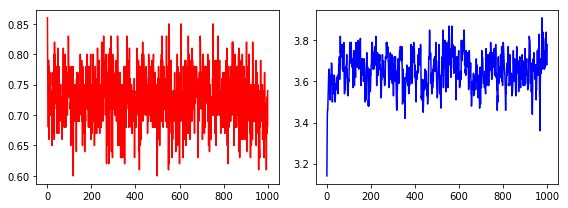

In [29]:
ratio_and_sum = sim.run_plot()
avgs = ratio_and_sum[0]
sums = ratio_and_sum[1]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].plot(range(1, num_observations_for_one_batch + 1), avgs, 'r')
axes[1].plot(range(1, num_observations_for_one_batch + 1), sums, 'b')
fig.tight_layout()
#fig.savefig('rand_50_2500.png')